### Libraries 📚⬇

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
%%time

# !git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt  # install dependencies
!cp yolov5/requirements.txt ./

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.5 MB/s eta 0:00:00
CPU times: user 106 ms, sys: 11.5 ms, total: 117 ms
Wall time: 10.7 s


## Loading Data 📝 / Preprocessing ⚙️

In [6]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv('/content/drive/MyDrive/workspace/Yolov5/new/data/train_solution_bounding_boxes (1).csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
print(df.head())

      image_id        xmin        ymin        xmax        ymax
0   vid_4_1000  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060   16.630970  186.546010  132.558611  238.386422


In [7]:
df['x_center'] = (df['xmin'] + df['xmax'])/2

In [8]:
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

image_id        xmin        ymin        xmax        ymax  x_center  \
0   vid_4_1000  281.259045  187.035071  327.727931  223.225547  0.450434   
1  vid_4_10000   15.163531  187.035071  120.329957  236.430180  0.100217   
2  vid_4_10040  239.192475  176.764801  361.968162  236.430180  0.444645   
3  vid_4_10020  496.483358  172.363256  630.020260  231.539575  0.833213   
4  vid_4_10060   16.630970  186.546010  132.558611  238.386422  0.110347   

   y_center         w         h  classes  
0  0.539817  0.068741  0.095238        0  
1  0.557191  0.155572  0.129987        0  
2  0.543678  0.181621  0.157014        0  
3  0.531451  0.197540  0.155727        0  
4  0.559122  0.171491  0.136422        0

In [9]:
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'/content/drive/MyDrive/workspace/Yolov5/new/data/training_images/{image}.jpg')
img.shape

Image ID: vid_4_21600


(380, 676, 3)

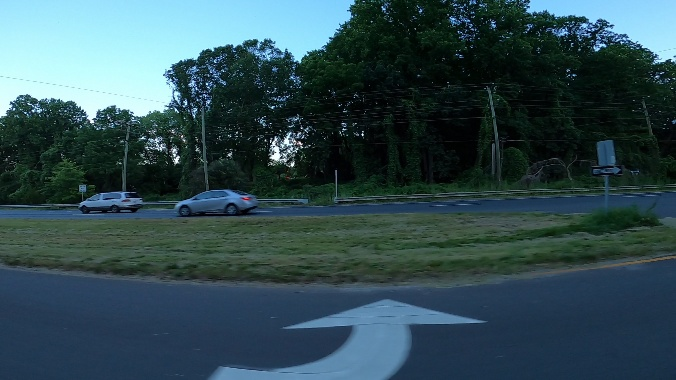

In [10]:
image = random.choice(index)
Image(filename=f'/content/drive/MyDrive/workspace/Yolov5/new/data/training_images/{image}.jpg',width=600)

## Training (Work in Progress)

In [11]:
import os
import shutil as sh
from tqdm import tqdm

source = 'training_images'
# os.makedirs('/data')

folds = [0]  # Define the list of fold values here

for fold in folds:
    # os.makedirs('/data/fold{}'.format(fold))
    val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
    for name, mini in tqdm(df.groupby('image_id')):
        if name in val_index:
            path2save = 'val2017/'
        else:
            path2save = 'train2017/'
        if not os.path.exists('data/fold{}/labels/'.format(fold)+path2save):
            os.makedirs('data/fold{}/labels/'.format(fold)+path2save)
        with open('data/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
            row = mini[['classes','x_center','y_center','w','h']].astype(float).values
            row = row.astype(str)
            for j in range(len(row)):
                text = ' '.join(row[j])
                f.write(text)
                f.write("\n")
        if not os.path.exists('data/fold{}/images/{}'.format(fold,path2save)):
            os.makedirs('data/fold{}/images/{}'.format(fold,path2save))
        sh.copy("/content/drive/MyDrive/workspace/Yolov5/new/data/{}/{}.jpg".format(source,name),'data/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))


100%|██████████| 355/355 [02:45<00:00,  2.15it/s]


In [12]:
!ls data/fold0/images/train2017

vid_4_10000.jpg  vid_4_16180.jpg  vid_4_21540.jpg  vid_4_600.jpg
vid_4_1000.jpg	 vid_4_16280.jpg  vid_4_21560.jpg  vid_4_6160.jpg
vid_4_10020.jpg  vid_4_16300.jpg  vid_4_21580.jpg  vid_4_6180.jpg
vid_4_10040.jpg  vid_4_16320.jpg  vid_4_21600.jpg  vid_4_6200.jpg
vid_4_10060.jpg  vid_4_16400.jpg  vid_4_2160.jpg   vid_4_6220.jpg
vid_4_10100.jpg  vid_4_16420.jpg  vid_4_21620.jpg  vid_4_6240.jpg
vid_4_10120.jpg  vid_4_16500.jpg  vid_4_21640.jpg  vid_4_6260.jpg
vid_4_10140.jpg  vid_4_16660.jpg  vid_4_21660.jpg  vid_4_6280.jpg
vid_4_1020.jpg	 vid_4_16680.jpg  vid_4_21680.jpg  vid_4_6300.jpg
vid_4_1040.jpg	 vid_4_16700.jpg  vid_4_2180.jpg   vid_4_6320.jpg
vid_4_10480.jpg  vid_4_16720.jpg  vid_4_2200.jpg   vid_4_6340.jpg
vid_4_10500.jpg  vid_4_17040.jpg  vid_4_22220.jpg  vid_4_6360.jpg
vid_4_10520.jpg  vid_4_17060.jpg  vid_4_22240.jpg  vid_4_6380.jpg
vid_4_1060.jpg	 vid_4_17080.jpg  vid_4_22540.jpg  vid_4_6400.jpg
vid_4_10960.jpg  vid_4_17100.jpg  vid_4_22560.jpg  vid_4_6420.jpg
vid_4_10980.jpg

In [13]:
%%writefile dataset.yaml
# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../data/fold0/  # dataset root dir
train: images/train2017 # train images (relative to 'path') 128 images
val: images/val2017  # val images (relative to 'path') 128 images
test:  # test images (optional)

# Classes (80 COCO classes)
names:
  0: car

Overwriting dataset.yaml


In [14]:
!python yolov5/train.py --batch 12 --epochs 12 --data dataset.yaml --weights yolov5s.pt --name yolov5x_fold0_new

train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=12, batch_size=12, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=yolov5x_fold0_new, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-163-g016e046 Python-3.10.11 torch-2.0.0+cu118 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=

## Stats

In [15]:
!ls yolov5/runs/train/yolov5x_fold0_new/weights/

best.pt  last.pt


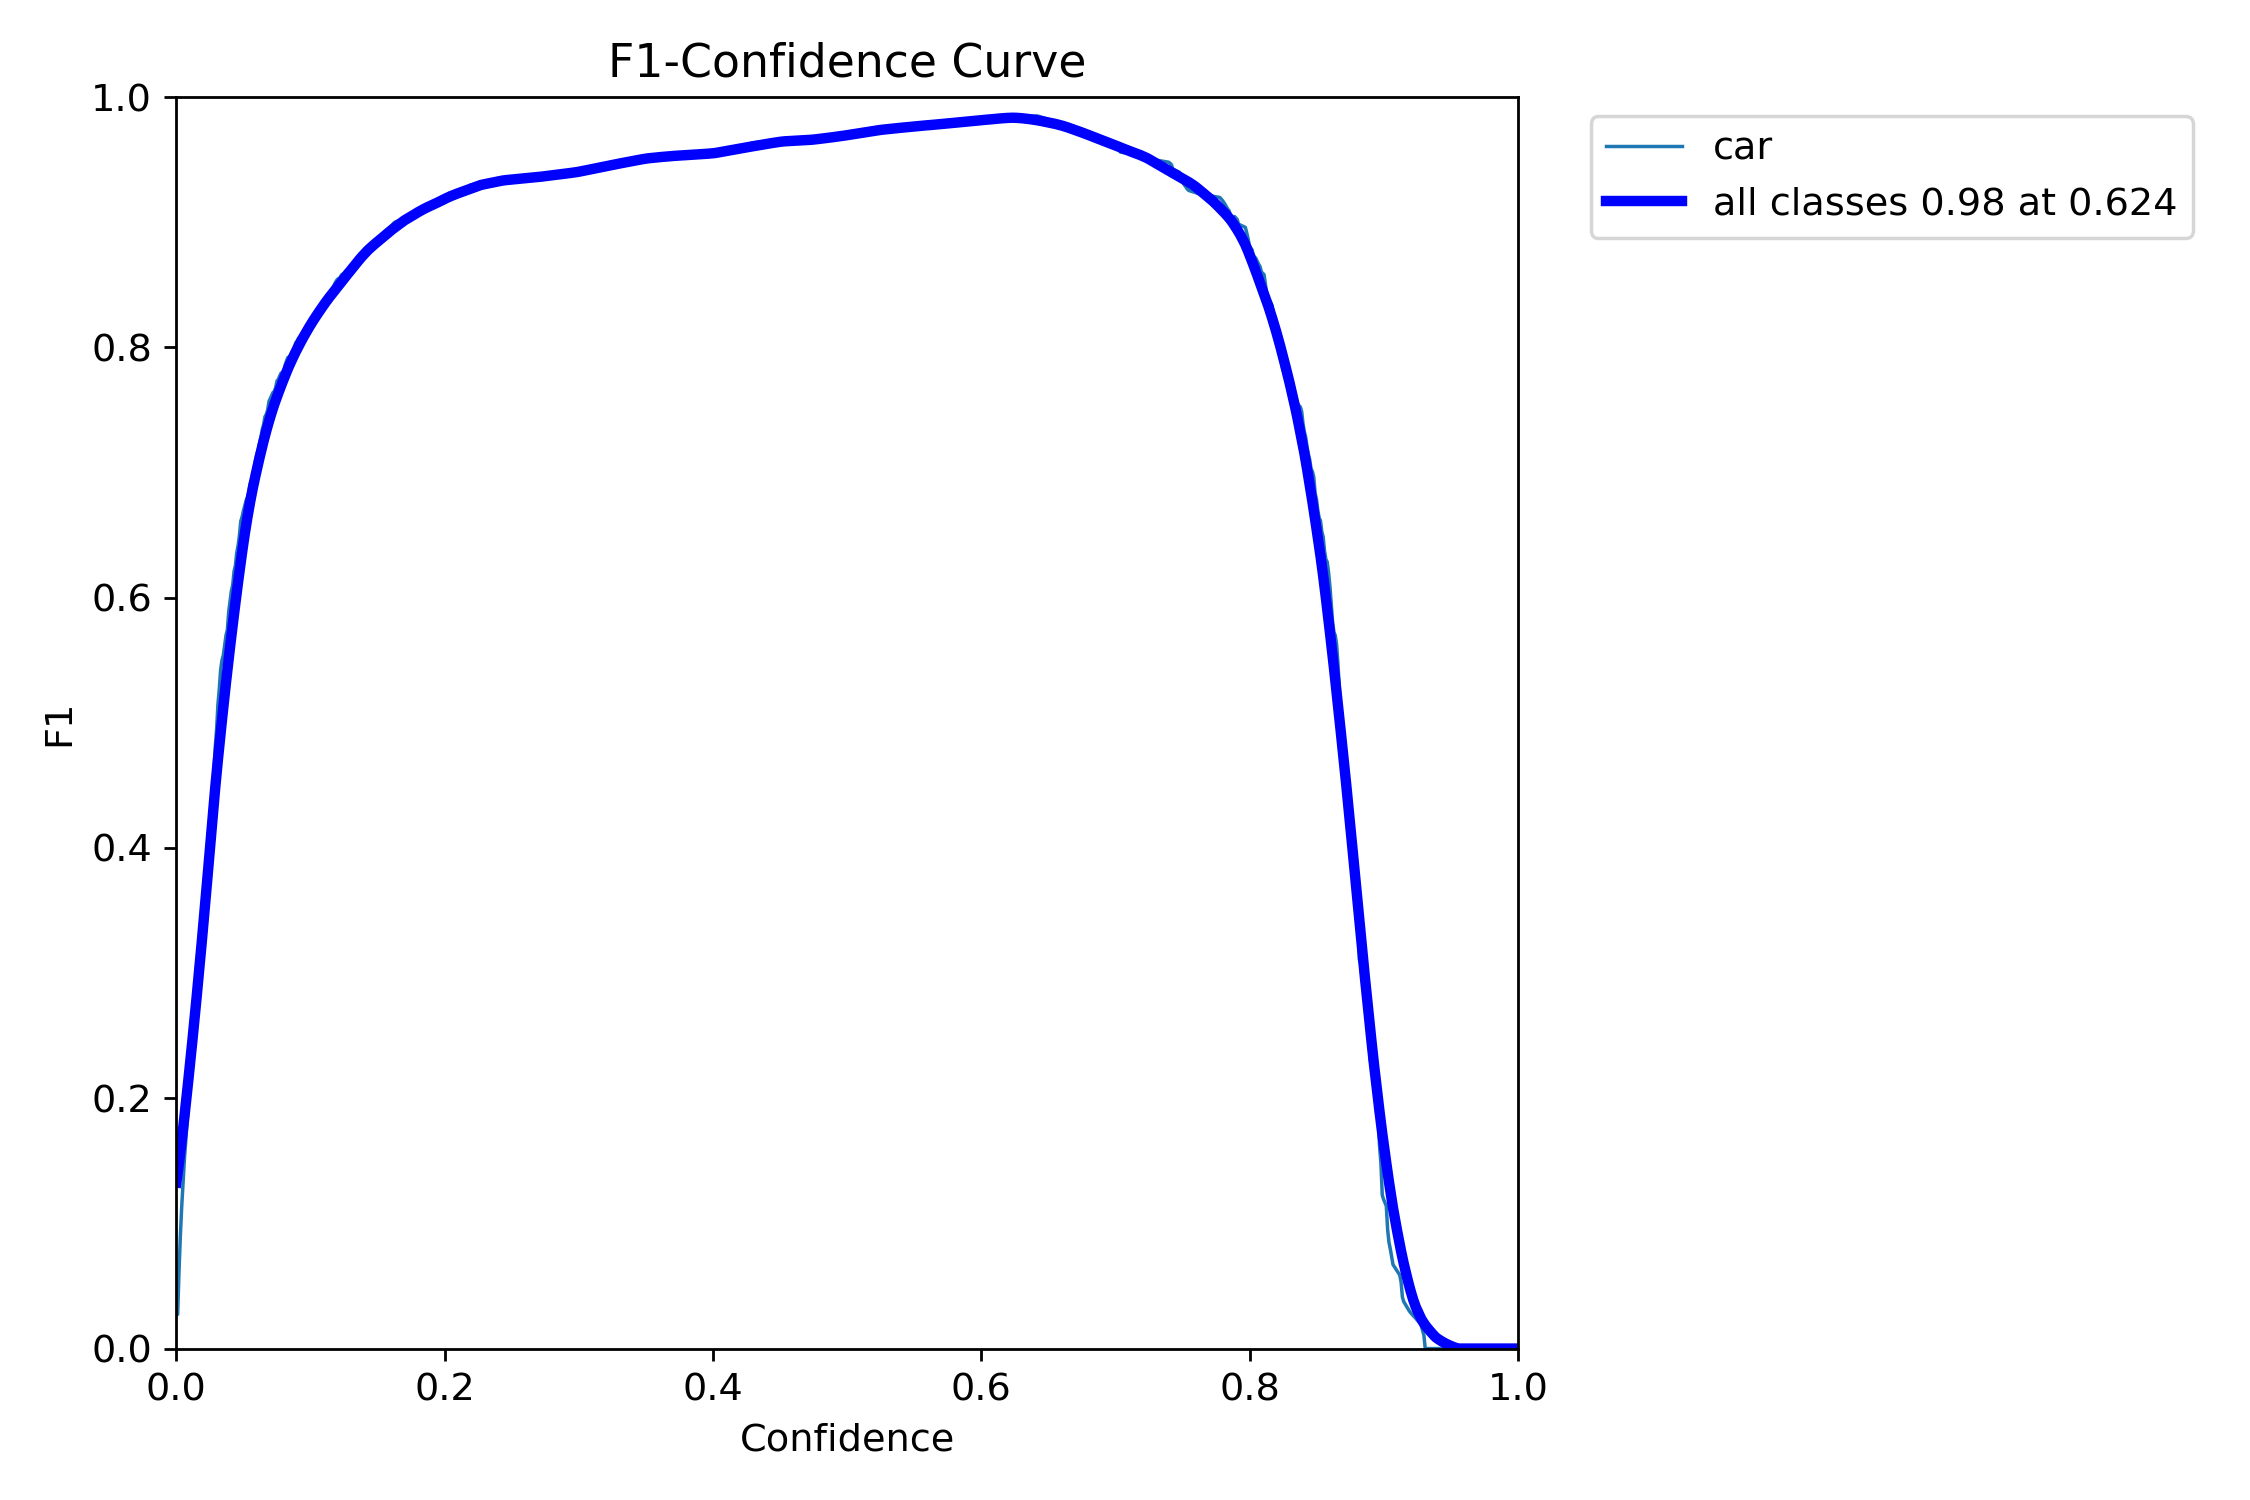

In [17]:
from PIL import Image
Image.open("yolov5/runs/train/yolov5x_fold0_new2/F1_curve.png")

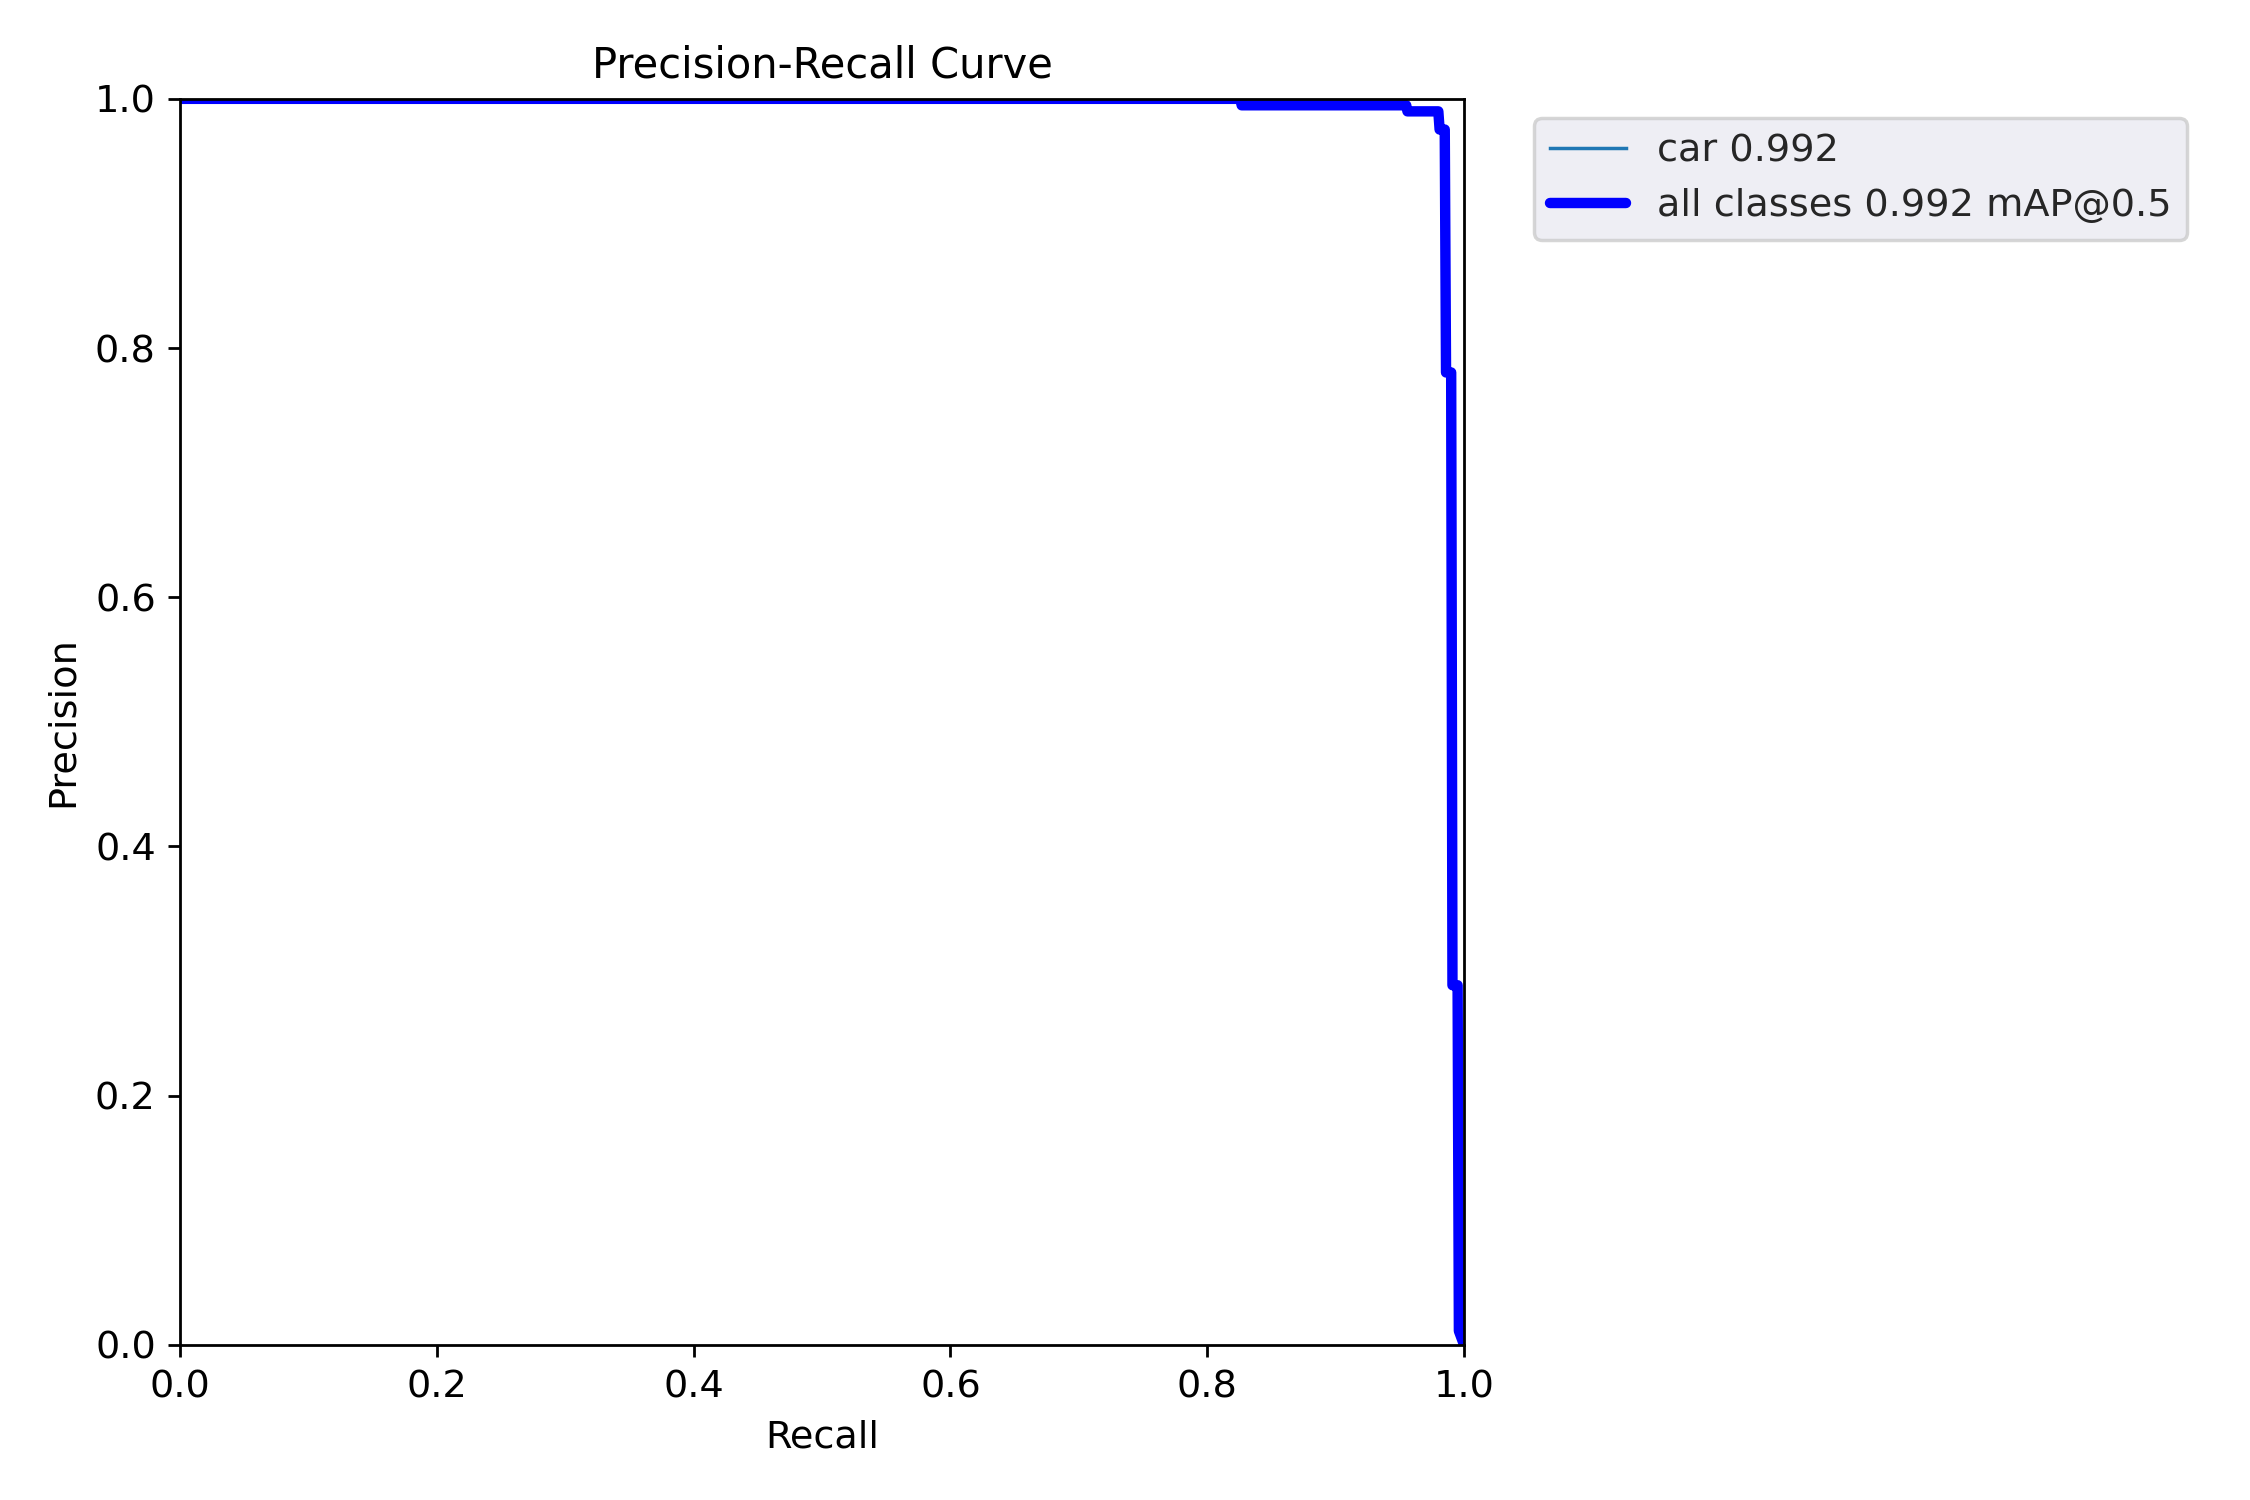

In [18]:
Image.open("yolov5/runs/train/yolov5x_fold0_new2/PR_curve.png")

## Prediction

In [19]:
!python yolov5/detect.py --weights yolov5/runs/train/yolov5x_fold0_new/weights/best.pt --img 676 --conf 0.6 --source /content/drive/MyDrive/workspace/Yolov5/new/data/testing_images

detect: weights=['yolov5/runs/train/yolov5x_fold0_new/weights/best.pt'], source=/content/drive/MyDrive/workspace/Yolov5/new/data/testing_images, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-163-g016e046 Python-3.10.11 torch-2.0.0+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/175 /content/drive/MyDrive/workspace/Yolov5/new/data/testing_images/vid_5_25100.jpg: 416x704 (no detections), 275.8ms
image 2/175 /content/drive/MyDrive/workspace/Yolov5/new/data/testing_images

In [20]:
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("./yolov5/runs/detect/exp"):
    predicted_files.extend(filenames)

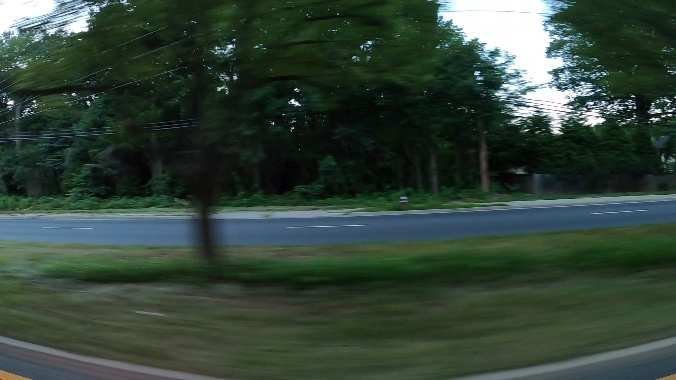

In [21]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

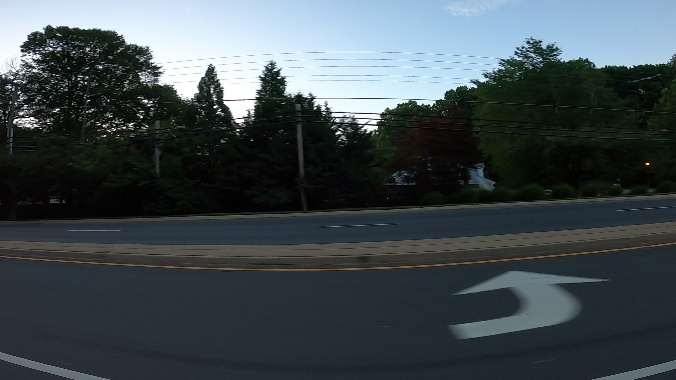

In [22]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

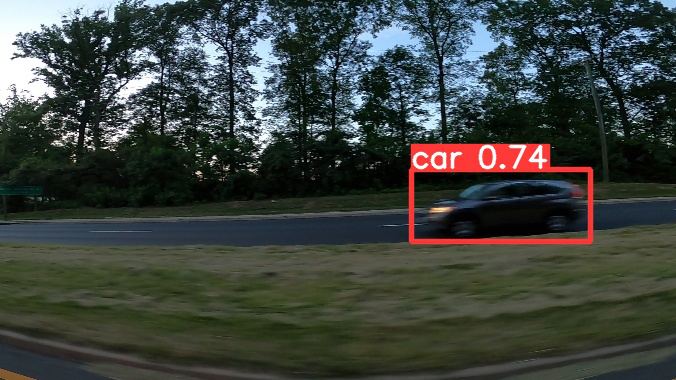

In [23]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

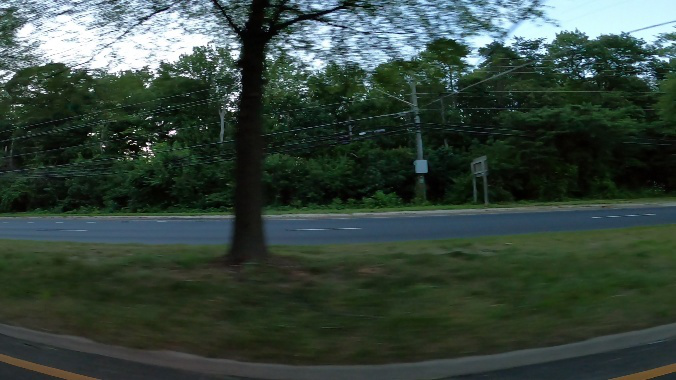

In [24]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

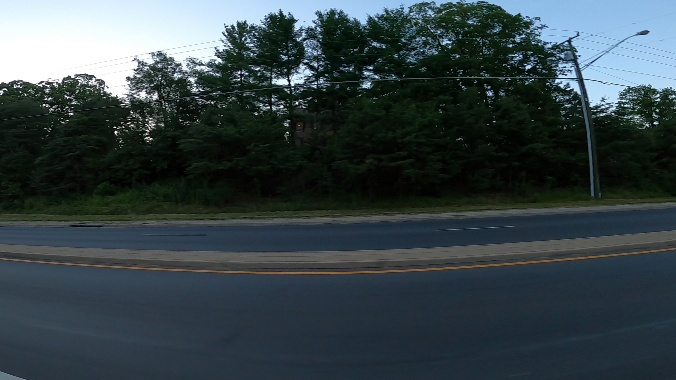

In [25]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

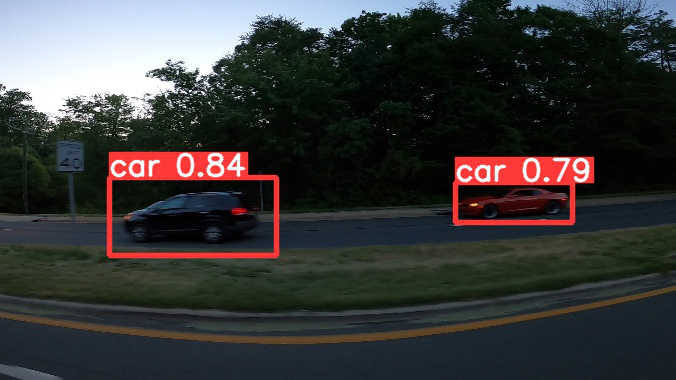

In [26]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

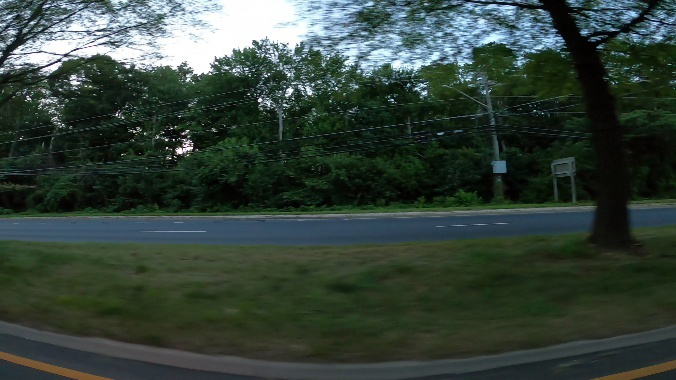

In [27]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

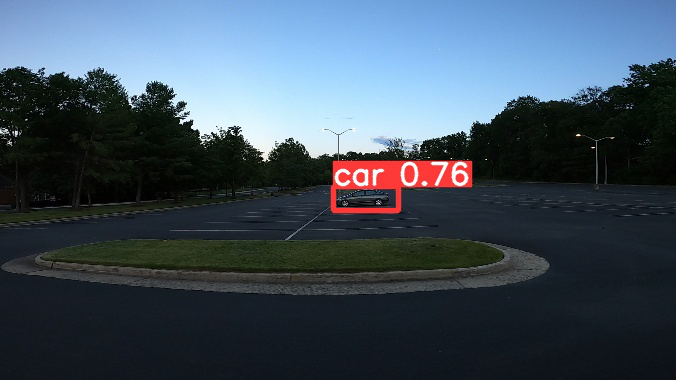

In [31]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

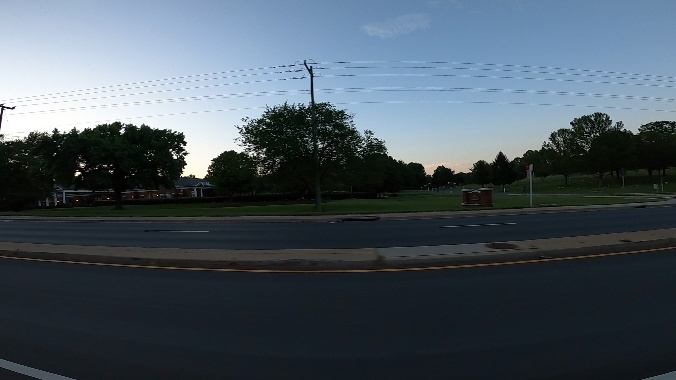

In [30]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

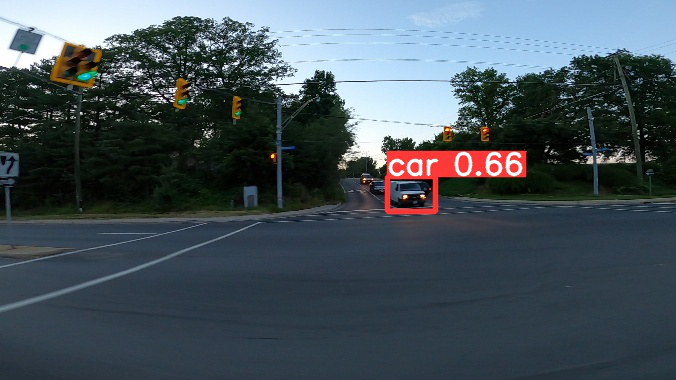

In [29]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')